blablabla

In [1]:
# import the libraries used
import os
from email.parser import Parser
from tqdm import tqdm
import json
import networkx as nx
import matplotlib.pyplot as plt
import path_calculator as pc
# set root directory of dataset
dataroot = os.path.join('..', 'EnronEmails_Filtered', 'maildir')

In [2]:
def splitEmails(maillist: str, tag):
    """
    Splits email of type tag [to,cc,bcc] addresses from maillist
    :param maillist: email with lists of addresses
    :param tag: tag specified to split from
    :return: list of split emails, Duplicates are included
    """
    split = maillist[tag]
    split = split.replace("\n", "")
    split = split.replace("\t", "")
    split = split.replace(" ", "")
    return split.split(',')

In [3]:
def readMail(email):
    """
    converts python email object into dict of dicts as written:
        {subject: "", text: "", tos: [], ccs: [], bccs: []}
    between all duplicates that existed in tos,ccs and bccs, are removed
    :param email: email being read
    :return: returns dict of dicts {subject: "", text: "", tos: [], cc: [], bcc: []}
    """
    update = {'subject': email['subject'], 'text': email.get_payload(), 'tos': [], 'ccs': [], 'bccs': []}
    if email['to']:
        update['tos'] = list(set(splitEmails(email, 'to')))
    if email['cc']:
        update['ccs'] = list(set(splitEmails(email, 'cc')))
        # This for if is O(n^2) it slows the parsing by a bit but it does remove duplicates in cc and bcc
        # Still takes around a minute
        for a in update['ccs']:
            if a in update['tos']:
                update['ccs'].remove(a)
    if email['bcc']:
        update['bccs'] = list(set(splitEmails(email, 'bcc')))
        for a in update['bccs']:
            if a in update['ccs']:
                update['bccs'].remove(a)
    return update

In [4]:
def addMail(dic, emailDir):
    """
    Add email from emailDir(a MIME file) into dic
    :param dic: dict to add email to
    :param emailDir: file from which the email are being read
    :return: updated dic
    """
    with open(emailDir, "r", encoding='utf-8', errors='ignore') as f:
        email = Parser().parsestr(f.read())
        key = email['from']
        if key in dic:
            value = dic.get(email['from'])
            value.append(readMail(email))
            dic.update({key: value})
        else:
            value = [readMail(email)]
            dic.update({key: value})

In [5]:
def addAll(dic, emailDir):
    """
    add all emails in emailDir(MIME file or directory) into dic
    :param dic: dict to add emails to
    :param emailDir: (MIME file or directory) from which the emails are being read
    :return: updated dic
    """
    if not os.path.isfile(emailDir):
        for file in os.listdir(emailDir):
            addAll(dic, os.path.join(emailDir, file))
    else:
        addMail(dic, emailDir)

In [6]:
def loadData(dic, root):
    """
    loads data from root into dic, tqdm progress bar indicates progress
    :param dic: dictionary that will be loaded with emails
    :param root: root directory
    :return: dic filled with data from root
    """
    for user in tqdm(os.listdir(root)):
        userPath = os.path.join(root, user)
        for folder in os.listdir(userPath):
            folderPath = os.path.join(root, user, folder)
            if os.path.isfile(folderPath):
                addMail(dic, folderPath)
                continue

            for file in os.listdir(folderPath):
                addAll(dic, os.path.join(dataroot, user, folder, file))

In [7]:
def _saveToFile(data, path):
    """
    ethan code ethan code
    :param data:
    :param path:
    :return:
    """
    print('Saving')
    with open(path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [8]:
class Edge:
    """
    Simple edge class that represents and edge with weight between 2 aliases
    """
    def __init__(self, alias1: str, alias2: str, weight=0):
        self.alias1 = alias1
        self.alias2 = alias2
        self.weight = weight

In [9]:
edges = {}
def addEdgeToDict(frm, to):
    """
    Adds edge from -> to to dictionary, incrementing weight if the tuple(frm, to) already exists in edges
    :param frm: from user
    :param to: to user
    :return: dictionary of edges key=tuple(frm,to):value=weight
    """
    key = tuple([frm, to])
    if key in edges:
        w = edges.get(key)
        w += 1
        edges[key] = w
    else:
        edges.update({key: 1})

load the intermediary file into myDict to avoid parsing through dataset each time
or if not created, create the intermediary file

In [10]:
myDict = {}
path = "../intermediary/file.json"
if os.path.isfile(path) and os.access(path, os.R_OK):
    print("Docs file found!")
    print('Reading...')
    with open(path, 'r') as f:
        myDict = json.load(f)
    print("...done!")

else:
    print("Either file is missing or is not readable, creating file...")
    loadData(myDict, dataroot)
    _saveToFile(myDict, path=path)

Docs file found!
Reading...
...done!


build networkx directed graph with edges

In [11]:
dG = nx.DiGraph()
G = nx.Graph()
print("\nBuilding Edges")
# weight dict
for _from in tqdm(myDict):
    emails = myDict.get(_from)
    for e in emails:
        for t in e['tos']:
            addEdgeToDict(_from, t)
        for c in e['ccs']:
            addEdgeToDict(_from, c)
        for b in e['bccs']:
            addEdgeToDict(_from, b)

print("\nBuilding Networkx")
for edge in tqdm(edges.keys()):
    dG.add_edge(edge[0], edge[1], weight=edges.get(edge))
    G.add_edge(edge[0], edge[1], weight=edges.get(edge))

print("\nDone.")

100%|██████████| 316767/316767 [00:01<00:00, 185183.57it/s]



Building Edges

Building Networkx

Done.


### (a)Degree distribution:

bla bla

#### Libraries Used
* networkx - used to the node degree for all nodes
* matplotlib - used to plot the histogram

Below is some code that gathers the node degrees of each node in the graph G and represents them as a histogram.

The node degree is the number of edges adjacent to the node.

A number of histograms are drawn to better visualize the distribution. Each plot will have comments '''inline'''
describing what the plot is visualizing.

#### Undirected Degree Distribution

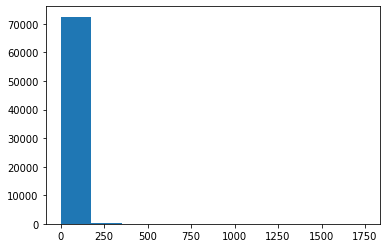

In [12]:
'''
The majority of nodes are connected less than 125 the node with the most connections reaches 1750.
'''
degrees = [G.degree(n) for n in G.nodes]
plt.hist(degrees)
plt.show()

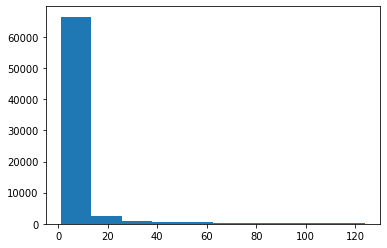

In [13]:
'''
From this histogram it is revealed that most nodes have a degree that is less than 20
'''
degrees = [G.degree(n) for n in G.nodes if G.degree(n) < 125]
plt.hist(degrees)
plt.show()

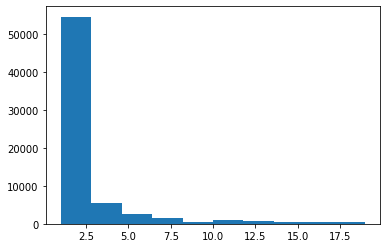

In [14]:
'''
From this histogram it is revealed that most nodes have a degree of 2
'''
degrees = [G.degree(n) for n in G.nodes if G.degree(n) < 20]
plt.hist(degrees)
plt.show()

In [15]:
nodes_more_than2 = len([G.degree(n) for n in G.nodes if G.degree(n) > 2])
print("Nodes that have a degree more than 2:")
print(nodes_more_than2)
print("Total number of nodes:")
print(len(G.nodes))

Nodes that have a degree more than 2:
18498
Total number of nodes:
73025


#### In Degree Distribution

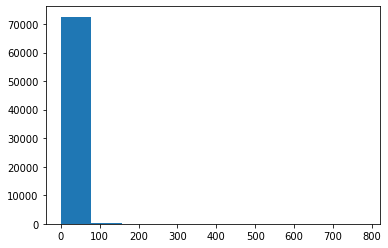

In [16]:
'''
The majority of nodes are connected less than 100 the node with the highest in degree reaches 800.
'''
degrees = [dG.in_degree(n) for n in dG.nodes]
plt.hist(degrees)
plt.show()

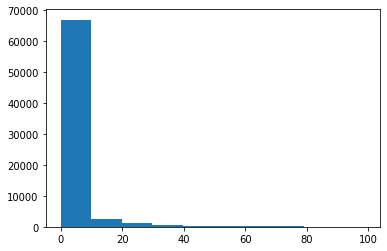

In [17]:
'''
From this histogram it is revealed that most nodes have an in-degree that is less than 10
'''
degrees = [dG.in_degree(n) for n in dG.nodes if dG.in_degree(n) <  100]
plt.hist(degrees)
plt.show()

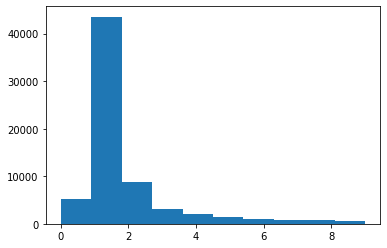

In [18]:
'''
From this histogram it is revealed that most nodes have an in-degree of 2, also a significant number have an in-degree
of 3
'''
degrees = [dG.in_degree(n) for n in dG.nodes if dG.in_degree(n) < 10]
plt.hist(degrees)
plt.show()

In [19]:
nodes_more_than3 = len([dG.in_degree(n) for n in dG.nodes if dG.in_degree(n) > 3])
print("Nodes that have a degree more than 3:")
print(nodes_more_than3)
print("Total number of nodes:")
print(len(dG.nodes))

Nodes that have a degree more than 3:
12371
Total number of nodes:
73025


#### Out Degree Distribution

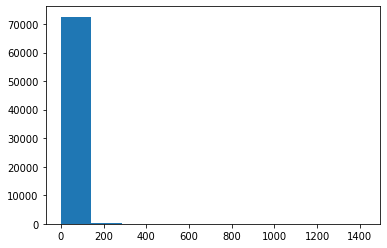

In [20]:
'''
The majority of nodes have an out-degree less than 100 the node with the highest out degree of 1400.
'''
degrees = [dG.out_degree(n) for n in dG.nodes]
plt.hist(degrees)
plt.show()

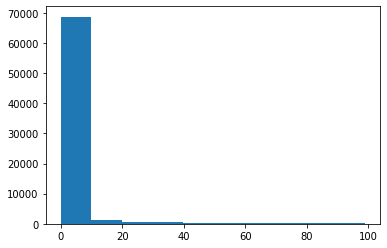

In [21]:
'''
From this histogram it is revealed that most nodes have an in-degree that is less than 10
'''
degrees = [dG.out_degree(n) for n in dG.nodes if dG.out_degree(n) <  100]
plt.hist(degrees)
plt.show()

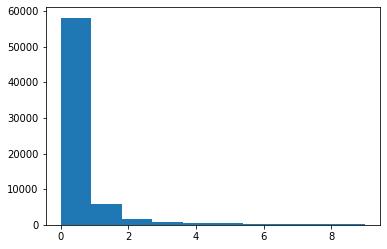

In [22]:
'''
From this histogram it is revealed that most nodes have an out-degree of 1
'''
degrees = [dG.out_degree(n) for n in dG.nodes if dG.out_degree(n) < 10]
plt.hist(degrees)
plt.show()

In [23]:
nodes_more_than1 = len([dG.out_degree(n) for n in dG.nodes if dG.out_degree(n) > 1])
print("Nodes that have an out degree more than 1:")
print(nodes_more_than1)
print("Total number of nodes:")
print(len(dG.nodes))

Nodes that have an out degree more than 1:
8964
Total number of nodes:
73025


In [24]:
def Pk(k):
    """
    :param k: degree that is being tested
    :return: degree distribution for the 2 graphs in all directions
    """
    Nk1 = len([dG.out_degree(n) for n in dG.nodes if dG.out_degree(n) == k])
    Nk2 = len([dG.in_degree(n) for n in dG.nodes if dG.in_degree(n) == k])
    Nk3 = len([G.degree(n) for n in G.nodes if G.degree(n) == k])

    return Nk1/len(dG.nodes), Nk2/len(dG.nodes), Nk3/len(G.nodes)

build subsets talk about how to build subsets

In [30]:
# closeness = nx.closeness_centrality(G)
# sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)
# by_closeness = sorted_closeness[-1]
# C_edges = {k: edges.get(k) for k in edges if k[0] == by_closeness or k[1] == by_closeness}
# CG = nx.DiGraph()
# for edge in C_edges.keys():
#     CG.add_edge(edge[0], edge[1], weight=C_edges.get(edge))

KeyboardInterrupt: 

In [39]:
degrees = nx.degree_centrality(G)
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
by_degree = sorted_degrees[-1]
D_edges = {k: edges.get(k) for k in edges if k[0] == by_degree[0] or k[1] == by_degree[0]}
DG = nx.DiGraph()
for edge in D_edges.keys():
    DG.add_edge(edge[0], edge[1], weight=D_edges.get(edge))

In [35]:
# betweenness = nx.betweenness_centrality_source(G, sources=[sorted_degrees[-1]])
# sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
# by_betweenness = sorted_betweenness[-1]
# B_edges = {k: edges.get(k) for k in edges if k[0] == by_betweenness or k[1] == by_betweenness}
# BG = nx.DiGraph()
# for edge in B_edges.keys():
#     BG.add_edge(edge[0], edge[1], weight= B_edges.get(edge))

KeyError: ('paul_syiek@thinkjobs.com', 1.369412795793164e-05)

In [40]:
# print(len(CG.nodes))
# print(len(BG.nodes))
print(len(DG.nodes))
print(len(dG.nodes))

2
73025


GX, LGX and G are too big

In [ ]:
#print(nx.diameter(iG.to_undirected()))
#print(nx.diameter(GX.to_undirected()))
#print(nx.diameter(LGX.to_undirected()))
